In [60]:
#%%
"""
Nov 5 2022
GP-limit continual learning theory for two-way classification problems.
1. EVERY RANDOM SEED CORRESPONDS TO A NEW RANDOM DATA SAMPLE!!!
2. The SAVE_SAMPLED_OUTPUTS controls whether some NN outputs are saved. If True, it will save the NN's output on the test set of the first dataset after training each task, which could take up a lot of disk space.
"""
SAVE_SAMPLED_OUTPUTS = False


import numpy as np
import utils, theory, cluster_utils, data, torch, sys
import matplotlib.pyplot as plt

ON_CLUSTER, data_path, output_home_path = cluster_utils.initialize()

NSEEDS = 20

parser = cluster_utils.Args()
parser.add('P', 500)  # size of each training set
parser.add('P_test', 100)  # size of each testing set
parser.add('n_tasks', 20, help='number of tasks in the sequence')
parser.add('T', 0.0, help='temperature')
parser.add('sigma', 0.2, help='weight variance')
parser.add('permutation', 1.0, help='permutation strength; 1.0=full permulation')
parser.add('resample', 1, help='boolean variable')
parser.add('depth', 3, help='num of hidden layers. setting depth=0 would use the input kernel')
parser.add('lambda_val', 1e5, help='lambda')
parser.add('task_type', 'permuted', help='permuted/split')
parser.add('dataset', 'mnist', help='mnist/cifar/fashion')
args = parser.parse_args()

all_train_losses = []
all_tr_magnitudes = []

for seed in range(NSEEDS):
    # Use the same seed for sampling the dataset etc.
        torch.manual_seed(seed)

        if args.task_type == 'permuted':
            seq_of_train_x, seq_of_test_x, seq_of_train_y, seq_of_test_y = \
                data.prepare_permuted_dataset(args.n_tasks, args.P, args.P_test, dataset_name=args.dataset,
                                            resample=bool(args.resample),
                                            permutation=args.permutation, data_path=data_path, precision=32)
        elif args.task_type == 'split':
            seq_of_train_x, seq_of_test_x, seq_of_train_y, seq_of_test_y = \
                data.prepare_split_dataset(args.P, args.P_test, dataset_name=args.dataset,
                                        data_path=data_path, precision=32, n_tasks=args.n_tasks)
        else:
            raise ValueError('task type not understood. Choose between "permuted" and "split"')

        training_predictions_naive, test_predictions_naive =\
            theory.compute_mean_predictions(seq_of_train_x=seq_of_train_x, seq_of_train_y=seq_of_train_y,
                                            w_var=args.sigma**2, P_test=args.P_test,
                                            lambda_val=args.lambda_val, seq_of_test_x=seq_of_test_x,
                                            large_lambda=True, depth=args.depth, use_naive_gp=True)

        train_loss_naive, _, _, _ =\
            data.get_loss_acc(training_predictions_naive, test_predictions_naive,
                            seq_of_train_y, seq_of_test_y)
        
        all_train_losses.append(train_loss_naive)
        all_tr_magnitudes.append(np.linalg.norm(training_predictions_naive.squeeze(), axis=-1)**2 / args.P)


all_train_losses = np.stack(all_train_losses)
all_tr_magnitudes = np.stack(all_tr_magnitudes)


/Users/haozheshan/Dropbox/codes/gp_continual_learning/theory.py:385: UserWarning: arccosine kernel computation is assuming that all inputs have the same norm.
  warnings.warn('arccosine kernel computation is assuming that all inputs have the same norm.')


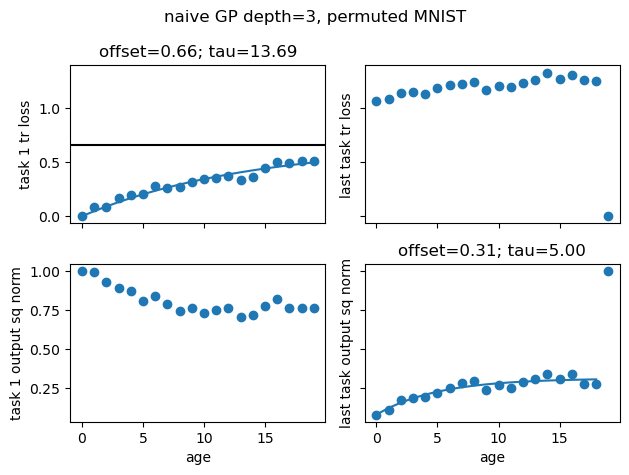

In [71]:

fig, axes = plt.subplots(ncols=2, nrows=2, sharey='row', sharex='col')
axes = axes.ravel()
plt.sca(axes[0])
plt.scatter(range(args.n_tasks), all_train_losses.mean(0)[0])
offset, tau = utils.exp_fit_and_plot(np.arange(args.n_tasks), all_train_losses.mean(0)[0], p0 = [1, 5])
plt.title(f'offset={offset:.2f}; tau={tau:.2f}')

plt.ylabel('task 1 tr loss')
plt.axhline(offset, color='k')

plt.sca(axes[1])
plt.scatter(range(args.n_tasks), all_train_losses.mean(0)[-1])

plt.ylabel('last task tr loss')

plt.sca(axes[2])
plt.ylabel('task 1 output sq norm')
plt.scatter(range(args.n_tasks), all_tr_magnitudes.mean(0)[0, :], label='magnitude of task 1 output')

plt.xlabel('age')

plt.sca(axes[3])
plt.ylabel('last task output sq norm')
plt.scatter(range(args.n_tasks), all_tr_magnitudes.mean(0)[-1, :], label='magnitude of last output')
offset, tau = utils.exp_fit_and_plot(np.arange(args.n_tasks-1), all_tr_magnitudes.mean(0)[-1, :args.n_tasks-1], p0 = [1, 5])
plt.title(f'offset={offset:.2f}; tau={tau:.2f}')
plt.xlabel('age')

plt.suptitle(f'naive GP depth={args.depth}, permuted MNIST')
plt.tight_layout()